# Анализ рекламных источников


Задача - проанализировать поведение игроков в зависимости от источника перехода.

- Провести исследовательский анализ данных;
- Проанализировать влияние источника перехода в игру на поведение пользователя;
- Проверить статистические гипотезы
    1. *Проверить гипотезу: время завершения уровня различается в зависимости способа прохождения:*
        - *через реализацию проекта,*
        - *через победу над первым игроком.*
    2. *Сформулировать собственную статистическую гипотезу. Дополнить её нулевой и альтернативной гипотезами. Проверить гипотезу с помощью статистического теста.*

#### Описание данных
Основной датасет содержит данные о событиях, совершенных в мобильной игре «Космические братья». В ней пользователи строят свою космическую программу и пытаются преуспеть в нелёгком деле колонизации галактики.

Основная монетизация игры — только планируется. Но предполагается, что в приложении будет происходить показ рекламы на экране с выбором типа объекта для постройки.

В датасете представлены данные по игре пользователей на первом уровне. Завершение первого уровня требует от игрока выполнения одного из двух условий:

- Победа над первым врагом
- Реализация проекта - разработка орбитальной сборки спутников

В датасете содержатся данные первых пользователей приложения — когорты пользователей, которые начали пользоваться приложением в период с 4 по 10 мая включительно.

Датасет *game_actions.csv*:

- `event_datetime` — время события;
- `event` — одно из трёх событий:
    1. `building` — объект построен,
    2. `finished_stage_1` — первый уровень завершён,
    3. `project` — проект завершён;
- `building_type` — один из трёх типов здания:
    1. `assembly_shop` — сборочный цех,
    2. `spaceport` — космопорт,
    3. `research_center` — исследовательский центр;
- `user_id` — идентификатор пользователя;
- `project_type` — тип реализованного проекта;

Помимо основного датасета есть два датасета с информацией о рекламных активностях. Они также помогут в решении задачи.

Датасет *ad_costs.csv*:

- `day` - день, в который был совершен клик по объявлению
- `source` - источник трафика
- `cost` - стоимость кликов

Датасет user_source.csv содержит колонки:

- `user_id` - идентификатор пользователя
- `source` - источников, с которого пришёл пользователь, установивший приложение

## Декомпозиция задачи

Исходная задача - проанализировать поведение игроков в зависимости от источника перехода.

Уточненная задача: 
- Проанализировать влияние источника перехода в игру на поведение пользователя
- Проверка гипотезы 1: время завершения уровня различается в зависимости способа прохождения:
    - через реализацию проекта,
    - через победу над первым игроком.
- Проверка гипотезы 2: Вводим дополнительную метрику - количество построек (предполагаем, что каждая показывает рекламу и монетизируется) -  в разбивке по каналам и дням/ расходы по каналу за день.  Назовем метрику конверсией. Гипотеза - конверсия различается в зависимости от канала привлечения пользователя.

Этапы
* Предобработка данных
* Исследовательский анализ данных
* Проверить влияние способа прохождения на время завершения уровня
    * Время завершения уровня определяем как разницу между временем события `finished_stage_1` и временем первого события для уникального пользователя
    * Группировка, визуализация
    * Формулирование и проверка гипотез z-тестом
    * Выводы
* Проверить влияние канала привлечения на конверсию
    * Рассчет конверсии, группировка, визуализация
    * Попарная проверка гипотез
    * Выводы
* Подготовка презентации
* Разработка дашборда
    1. Построить диаграмму распределения количества построенных объектов
    2. Добавить индикатор количества пользователей
    3. Добавить фильтр дашборда по признаку завершения уровня

# Предобработка данных

In [84]:
#Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import datetime as dt
import seaborn as sb
import os

Загружаем данные

In [85]:
#Функция для чтения таблиц
def read_table(name):
    pth1 = '/datasets/' + name + '.csv'
    pth2 = 'C:\\Users\\ryzig\YandexDisk\Data analyst Yandex 2022\Проекты\Diploma project\\' + name + '.csv'
    pth3 = 'F:/YandexDisk/Data analyst Yandex 2022/Проекты/Diploma project/' + name +'.csv'

    if os.path.exists(pth1):
        table = pd.read_csv(pth1, sep=',')
    elif os.path.exists(pth2):
        table = pd.read_csv(pth2, sep=',')
    elif os.path.exists(pth3):
        table = pd.read_csv(pth3, sep=',')
    else:
        print('Something is wrong - ', pth1)
        return
    return table


game_actions = read_table('game_actions')
ad_costs = read_table('ad_costs')
user_source = read_table('user_source')

tables = [game_actions, ad_costs, user_source]

In [86]:
#функция для предварительного просмотра данных
def describing_data(df):
    display(df.head())
    print('*'*50)
    df.info()
    print('*'*50)
    display(df.describe())
    print('*'*50)
    print('Явных дубликатов: ', table.duplicated().sum())

In [87]:
for table in tables:
    describing_data(table)
    print('_'*50)

,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN


**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_datetime  135640 non-null  object
 1   event           135640 non-null  object
 2   building_type   127957 non-null  object
 3   user_id         135640 non-null  object
 4   project_type    1866 non-null    object
dtypes: object(5)
memory usage: 5.2+ MB
**************************************************


,event_datetime,event,building_type,user_id,project_type
count,135640,135640,127957,135640,1866
unique,128790,3,3,13576,1
top,2020-05-09 12:35:56,building,spaceport,bf542075-e3a2-4e79-82d8-3838e86d2a25,satellite_orbital_assembly
freq,4,127957,59325,22,1866


**************************************************
Явных дубликатов:  1
__________________________________________________


,source,day,cost
0,facebook_ads,2020-05-03,935.882786
1,facebook_ads,2020-05-04,548.354480
2,facebook_ads,2020-05-05,260.185754
3,facebook_ads,2020-05-06,177.982200
4,facebook_ads,2020-05-07,111.766796


**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  28 non-null     object 
 1   day     28 non-null     object 
 2   cost    28 non-null     float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes
**************************************************


,cost
count,28.000000
mean,271.556321
std,286.867650
min,23.314669
25%,66.747365
50%,160.056443
75%,349.034473
max,969.139394


**************************************************
Явных дубликатов:  0
__________________________________________________


,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads


**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  13576 non-null  object
 1   source   13576 non-null  object
dtypes: object(2)
memory usage: 212.2+ KB
**************************************************


,user_id,source
count,13576,13576
unique,13576,4
top,0001f83c-c6ac-4621-b7f0-8a28b283ac30,yandex_direct
freq,1,4817


**************************************************
Явных дубликатов:  0
__________________________________________________


Работаем с `game_actions`

In [88]:
#меняем тип данных для event_datetime
game_actions['event_datetime'] = pd.to_datetime(game_actions.event_datetime)
#выделяем отдельно дату
game_actions['date'] = game_actions.event_datetime.dt.date

Всего 1 явный дубликат, удаляем его

In [89]:
game_actions = game_actions.drop_duplicates().reset_index()

In [90]:
game_actions.event.value_counts()

building            127956
finished_stage_1      5817
project               1866
Name: event, dtype: int64

В столбце `event` отсутствуют пропуски, есть три понятных категории:
* построено здание (показана реклама)
* завершен уровень 1
* завершен проект 

In [91]:
game_actions.building_type.value_counts()

spaceport          59325
assembly_shop      54494
research_center    14137
Name: building_type, dtype: int64

В столбце `building_type` есть пропуски, также есть три вида зданий. Пропуски, очевидно, связаны с тем, что события по данным строкам  - это не постройка зданий. Заменим пропуски предопределенным значением "not_acceptable", которое можно будет фильтровать по необходимости.

In [92]:
game_actions['building_type'] = game_actions['building_type'].fillna('not_acceptable')

In [93]:
game_actions.project_type.value_counts()

satellite_orbital_assembly    1866
Name: project_type, dtype: int64

Тип проекта указан только для части строк. Посмотрим, для каких.

In [94]:
game_actions[~game_actions['project_type'].isna()].head()

,index,event_datetime,event,building_type,user_id,project_type,date
47121,47121,2020-05-08 18:10:25,project,not_acceptable,e3c66498-9d45-4000-9392-f81e6796e7da,satellite_orbital_assembly,2020-05-08
57398,57398,2020-05-09 13:49:11,project,not_acceptable,936e7af6-8338-4703-a1df-fc6c3f5b8e34,satellite_orbital_assembly,2020-05-09
58797,58797,2020-05-09 16:19:33,project,not_acceptable,a4491c86-c498-4f74-a56e-65c136d0e9a1,satellite_orbital_assembly,2020-05-09
61174,61174,2020-05-09 20:29:01,project,not_acceptable,85d9e675-562b-4329-8bbd-14d3b39096be,satellite_orbital_assembly,2020-05-09
63770,63770,2020-05-10 00:57:47,project,not_acceptable,1889ca71-3c57-4e61-9ea6-a711971bbf0a,satellite_orbital_assembly,2020-05-10


Очевидно, тип проекта указан только для событий с типом project, и он только одного вида, того самого который дает право перехода на уровень 1. Заполним пропуски в данном столбце также предопределенным значением "not_acceptable", которое можно будет фильтровать по необходимости.

In [95]:
game_actions['project_type'] = game_actions['project_type'].fillna('not_acceptable')

Работаем с `ad_costs`

In [96]:
ad_costs.day = pd.to_datetime(ad_costs.day).dt.date

In [97]:
ad_costs.day.value_counts()

2020-05-03    4
2020-05-04    4
2020-05-05    4
2020-05-06    4
2020-05-07    4
2020-05-08    4
2020-05-09    4
Name: day, dtype: int64

In [98]:
ad_costs.source.value_counts()

facebook_ads               7
instagram_new_adverts      7
yandex_direct              7
youtube_channel_reklama    7
Name: source, dtype: int64

Работаем с `user_source`

In [99]:
user_source.source.value_counts()

yandex_direct              4817
instagram_new_adverts      3347
facebook_ads               2726
youtube_channel_reklama    2686
Name: source, dtype: int64

В таблицах ad_costs и user_source проблем не обнаружено, дубликаты и пропуски отсутствуют.

### Вывод

Данные предобработаны и готовы к анализу.

# Исследовательский анализ данных

Прежде всего соединим все три таблицы в одну, так будет удобнее для дальнейших шагов. Сначала присоединим методом merge таблицу источников по пользователям к таблице событий. Определим дату первого события для каждого пользователя. Затем присоединим расходы на источник за эту дату.

In [101]:
#Присоединяем источники по пользователям. Данные будем аккумулировать в новом датафрейме data
data = game_actions.merge(user_source, how='left', on='user_id')

#определяем время первого события для каждого пользователя
first_event_time = (
    data.groupby('user_id')['event_datetime']
    .agg('min')
    .sort_values()
    .reset_index()
    .rename(columns={'event_datetime': 'first_event_time'})
)
#и присоединяем к датасету по пользователю
data = data.merge(first_event_time, on='user_id')
#выделяем отдельно дату первого события
data['first_event_date'] = data['first_event_time'].dt.date
#присоединяем стоимость кликов в разбивке по датам и источникам
data = data.merge(ad_costs, how='left', left_on=['first_event_date', 'source'], right_on=['day', 'source'])
data = data.drop('day', axis=1)
data.head()

,index,event_datetime,event,building_type,user_id,project_type,date,source,first_event_time,first_event_date,cost
0,0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,not_acceptable,2020-05-04,youtube_channel_reklama,2020-05-04 00:00:01,2020-05-04,259.073224
1,10101,2020-05-05 05:20:15,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,not_acceptable,2020-05-05,youtube_channel_reklama,2020-05-04 00:00:01,2020-05-04,259.073224
2,15489,2020-05-05 19:24:02,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,not_acceptable,2020-05-05,youtube_channel_reklama,2020-05-04 00:00:01,2020-05-04,259.073224
3,16114,2020-05-05 20:59:19,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,not_acceptable,2020-05-05,youtube_channel_reklama,2020-05-04 00:00:01,2020-05-04,259.073224
4,17607,2020-05-06 00:52:56,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,not_acceptable,2020-05-06,youtube_channel_reklama,2020-05-04 00:00:01,2020-05-04,259.073224


Рассчитаем время прохождения уровня 1

In [102]:
#группируем данные
timings = data.query(
    'event == "finished_stage_1"'
).groupby('user_id')[['event_datetime', 'first_event_time']].agg('min').reset_index()
#вычисляем время
timings['time_for_stage_1'] = timings['event_datetime'] - timings['first_event_time']
#удаляем лишнее
timings = timings.drop(['event_datetime', 'first_event_time'], axis=1)
timings
#присоединяем к датасету
data = data.merge(timings, how='left', on='user_id')
#data.info()

Создадим дополнительный признак, который определяет способ прохождения 1 уровня пользователем. Будем считать, что если у пользователя в событиях есть событие "project" одновременно с наличием события "finished_stage_1", то такой пользователь прошел уровень через реализацию проекта, иначе - через победу над первым игроком. Если у пользователя нет события "finished_stage_1", в этом же признаке укажем, что он не прошел уровень 1. 

In [103]:
#ограничим данные нужной выборкой для быстроты обработки
data_limit = data[['event', 'user_id']].query('event in ["finished_stage_1", "project"]')
#добавляем единицу для каждой строки, чтобы подсчитать количество событий в своде
data_limit['count'] = 1
#сворачиваем, заменяем n/a 0
type_features = data_limit.pivot(index='user_id', columns='event', values='count').fillna(0).reset_index()

#создаем функцию классификации
def definer(row):
    if row.finished_stage_1 == 1:
        if row.project == 1:
            return 'project'
        else:
            return 'battle'
    else:
        return 'stage1_not_finished'

#применяем    
type_features['type'] = type_features.apply(definer, axis=1)
type_features.type.value_counts()

battle     3951
project    1866
Name: type, dtype: int64

In [104]:
#мерджим данные с основным датасетом
data = data.merge(type_features[['user_id', 'type']], how='left', on='user_id')

In [105]:
#пропуски заполняем значением 'stage1_not_finished'
data['type'] = data['type'].fillna('stage1_not_finished')
data.type.value_counts()

stage1_not_finished    67170
battle                 41136
project                27333
Name: type, dtype: int64

Отфильтруем прошедших уровень 1 и оценим влияние способа прохождения на время прохождения

In [106]:
#конвертируем timedelta в секунды
data['time_for_stage_1'] = data['time_for_stage_1'].astype('timedelta64[h]')
#группируем по id и способу прохождения, чтобы получить время уникального пользователя
time_for_type = (
    data.query('event == "finished_stage_1"')
    .groupby(['user_id', 'type'])['time_for_stage_1']
    .agg('mean')
    .reset_index()
)
time_for_type.head(10)

,user_id,type,time_for_stage_1
0,001d39dc-366c-4021-9604-6a3b9ff01e25,battle,154.0
1,003ee7e8-6356-4286-a715-62f22a18d2a1,battle,301.0
2,004074f8-251a-4776-922c-8348dca1a2f6,battle,306.0
3,00464e5e-28ed-4be6-bf44-517ef7b3937b,battle,271.0
4,0056c007-c082-43cc-bdef-afc49bca4cb9,battle,145.0
5,005ff87b-b475-4da7-862e-57ab91adbff4,battle,213.0
6,00606a1c-51e1-48d1-b053-77be528527c0,battle,334.0
7,006380d6-67a6-45de-ab1e-6eb54ad8dbe8,project,282.0
8,007ad796-add4-41a5-bc2a-e11561f16cd6,battle,314.0
9,007f9ffa-4c39-408b-a2e1-a84ddc10bee1,battle,188.0


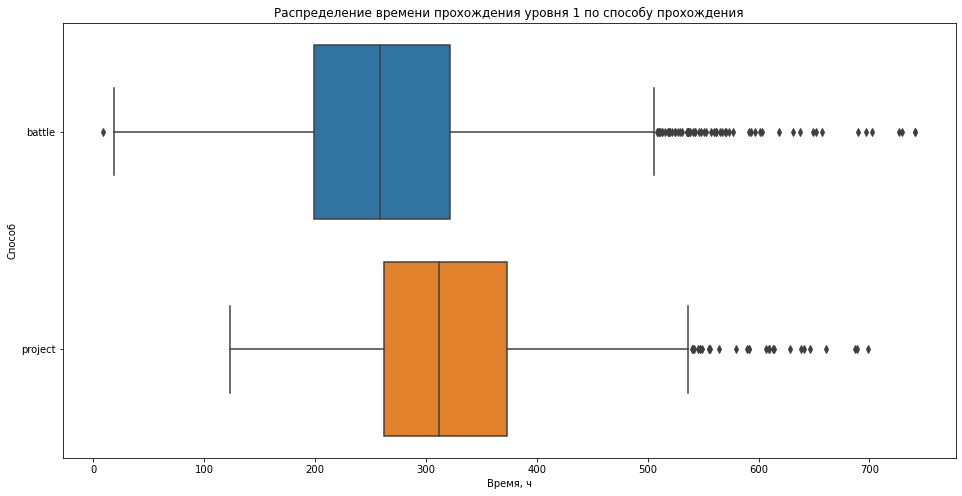

In [107]:
#визуализируем
plt.figure(figsize=(16,8))
sb.boxplot(x='time_for_stage_1', y='type', data=time_for_type)
plt.title('Распределение времени прохождения уровня 1 по способу прохождения')
plt.xlabel('Время, ч')
plt.ylabel('Способ')
plt.show()

Визуально различие довольно заметно, далее будем проверять его статистически

Взглянем на количество уникальных пользователей по источникам привлечения

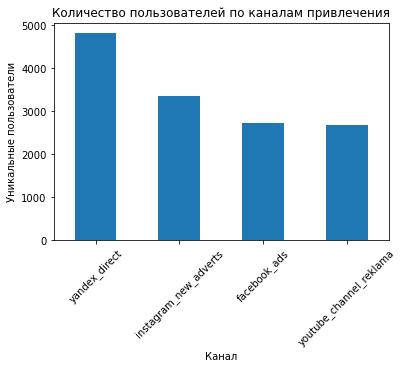

In [110]:
(
data
    .groupby('source')['user_id']
    .agg('nunique')
    .sort_values(ascending=False)
    .plot(kind='bar')
)
plt.xticks(rotation=45)
plt.title('Количество пользователей по каналам привлечения')
plt.xlabel('Канал')
plt.ylabel('Уникальные пользователи')
plt.show()

Количество построенных зданий (монетизированные события) по источникам привлечения

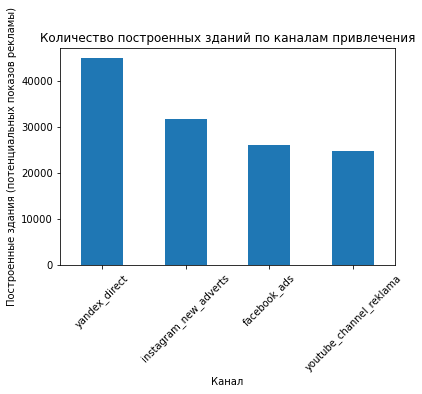

In [111]:
(
data
    .query('event == "building"')
    .groupby('source')['user_id']
    .agg('count')
    .sort_values(ascending=False)
    .plot(kind='bar')
)
plt.xticks(rotation=45)
plt.title('Количество построенных зданий по каналам привлечения')
plt.xlabel('Канал')
plt.ylabel('Построенные здания (потенциальных показов рекламы)')
plt.show()

В датасете содержатся данные первых пользователей приложения — когорты пользователей, которые начали пользоваться приложением в период с 4 по 10 мая включительно.

In [112]:
ad_costs.groupby('day').agg('count')

,source,cost
day,,
2020-05-03,4,4
2020-05-04,4,4
2020-05-05,4,4
2020-05-06,4,4
2020-05-07,4,4
2020-05-08,4,4
2020-05-09,4,4


Данные по затратам на привлечение пользователей доступны с 3 по 9 мая включительно. Ограничим датасет пользователями, привлеченными по известной нам стоимости. Удалим когорту от 10 мая.

In [113]:
data_cut = data[data['first_event_date'] < pd.to_datetime("2020-05-10").date()]
data_cut.first_event_date.value_counts()

2020-05-04    64226
2020-05-05    34756
2020-05-06    17399
2020-05-07     9429
2020-05-08     5121
2020-05-09     3025
Name: first_event_date, dtype: int64

In [114]:
#количество удаленных данных
print("Удалено " + str(len(data) - len(data_cut)) + " строк,")
print("что составляет " + str(round((len(data) - len(data_cut)) * 100 / len(data), 1)) + " % данных.")      

Удалено 1683 строк,
что составляет 1.2 % данных.


Предположим, каждый показ рекламе на этапе выбора постройки будет приносить нам 1 условную денежную единицу. Рассчитаем количество построенных зданий по источникам привлечения

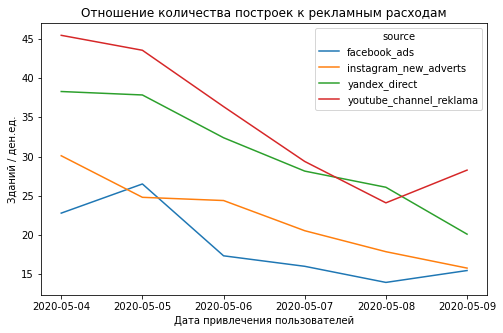

In [115]:
(
data_cut
    .query('event == "building"')
    .pivot_table(index='first_event_date', columns='source', values='event', aggfunc='count') / 
data_cut
    .query('event == "building"')
    .pivot_table(index='first_event_date', columns='source', values='cost', aggfunc='mean')

).plot(figsize=(8,5))

plt.title('Отношение количества построек к рекламным расходам')
plt.xlabel('Дата привлечения пользователей')
plt.ylabel('Зданий / ден.ед.')

plt.show()

Данный график говорит об изменении качества трафика по дням

Рассчитаем и визуализируем среднюю стоимость привлечения одного пользователя

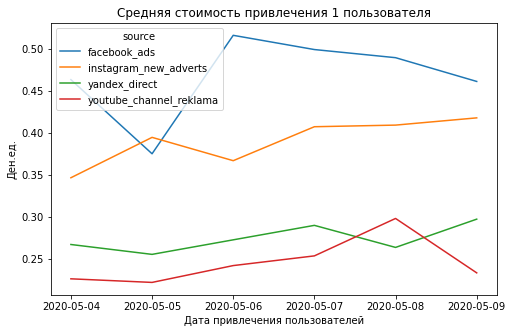

In [116]:
(
data_cut
    .pivot_table(index='first_event_date', columns='source', values='cost', aggfunc='mean') / 
data_cut
    .pivot_table(index='first_event_date', columns='source', values='user_id', aggfunc='nunique')

).plot(figsize=(8,5))

plt.title('Средняя стоимость привлечения 1 пользователя')
plt.xlabel('Дата привлечения пользователей')
plt.ylabel('Ден.ед.')

plt.show()

### Промежуточные выводы

Диаграммы размаха показывают, что для достижения 1 уровня победой над другим игроком требуется немного меньше времени.

Со значительным отрывом как по привлечению пользователей, так и по потенциальной монетизации этих пользователей лидирует источник yandex_direct

Количество построек (удельное, в расчет на понесенные затраты на привлечение) со временем значительно снижается. Это говорит о том, что рекламные средства в последний день используются менее эффективно, чем в первый. Возможно, игроки поняли, что через победу над игроком достичь первого уровня проще, в связи с этим количество построек сокращается.

Стоимость привлечения 1 пользователя по источникам facebook и instagram значительно выше yandex и youtube. При этом, как по количеству привлеченных пользователей, так и по потенциальной монетизации от этих пользователей в рамках предложенной модели эти каналы чуть выше youtube и сильно ниже yandex.

# Гипотеза 1. Проверка влияния способа прохождения на время завершения уровня

Формулировка нулевой гипотезы -  

Время завершения не различается в зависимости способа прохождения:
* через реализацию проекта,
* через победу над первым игроком.

Альтернативная гипотеза - они различаются.

Мы имеем дело с двумя независимыми выборками из одной генеральной совокупности. Поэтому для проверки гипотезы о равенстве средних будем использовать t-тест

In [117]:
#формируем выборки
fighters = time_for_type.query('type == "battle"')['time_for_stage_1']
builders = time_for_type.query('type == "project"')['time_for_stage_1']

alpha = 0.01

results = stats.ttest_ind(
    fighters, 
    builders)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 7.408867041388203e-98
Отвергаем нулевую гипотезу


Значение p-value очень близко к нулю. Нулевая гипотеза должна быть отвергнута. Принимается альтернативная гипотеза.

### Вывод

Время завершения статистически различается в зависимости от способа прохождения 1го уровня.

# Гипотеза 2. Проверка влияния канала привлечения на количество построенных пользователем данных

Формулировка нулевой гипотезы -

Количество построенных зданий (потенциальные события монетизации) по привлеченным пользователям не различается от канала привлечения пользователя.

Альтернативная гипотеза - они различаются.

Мы имеем дело с четырьмя независимыми выборками из одной генеральной совокупности. Поэтому для проверки гипотезы о равенстве средних будем использовать попарные t-тесты

In [118]:
#группируем и готовим выборки
buildings = data.query('event == "building"').groupby(['user_id', 'source'])['event'].agg('count').reset_index()
sources = buildings['source'].unique()

alpha = 0.05

#считаем p-value в цикле
for source1 in sources:
    for source2 in sources:
        if source1 == source2:
            continue
        print('_____')
        print('Сравниваем ' + source1 + ' и ' + source2)
        results = stats.ttest_ind(
            buildings.query('source == @source1')['event'],
            buildings.query('source == @source2')['event'])
        print('p-значение:', results.pvalue)
        if results.pvalue < alpha:
            print("Отвергаем нулевую гипотезу")
        else:
            print("Не получилось отвергнуть нулевую гипотезу")


_____
Сравниваем facebook_ads и yandex_direct
p-значение: 0.010411759321497693
Отвергаем нулевую гипотезу
_____
Сравниваем facebook_ads и youtube_channel_reklama
p-значение: 0.006588846148210501
Отвергаем нулевую гипотезу
_____
Сравниваем facebook_ads и instagram_new_adverts
p-значение: 0.4185321366657372
Не получилось отвергнуть нулевую гипотезу
_____
Сравниваем yandex_direct и facebook_ads
p-значение: 0.010411759321497693
Отвергаем нулевую гипотезу
_____
Сравниваем yandex_direct и youtube_channel_reklama
p-значение: 0.5972890424874877
Не получилось отвергнуть нулевую гипотезу
_____
Сравниваем yandex_direct и instagram_new_adverts
p-значение: 0.06989780662351841
Не получилось отвергнуть нулевую гипотезу
_____
Сравниваем youtube_channel_reklama и facebook_ads
p-значение: 0.006588846148210501
Отвергаем нулевую гипотезу
_____
Сравниваем youtube_channel_reklama и yandex_direct
p-значение: 0.5972890424874877
Не получилось отвергнуть нулевую гипотезу
_____
Сравниваем youtube_channel_reklama

Нулевая гипотеза отвернута в парах:

facebook_ads и youtube_channel_reklama,

yandex_direct и facebook_ads,

instagram_new_adverts и youtube_channel_reklama

### Вывод

* Пользователи пришедшие из каналов facebook_ads и youtube_channel_reklama статистически значимо различаются по количеству построенных зданий. В соответствии с ранее сделанным анализом youtube_channel_reklama выигрывает по соотношению здания/затраты на рекламу, однако проигрывает по количеству привлеченных пользователей.

* Пользователи пришедшие из каналов yandex_direct и facebook_ads статистически значимо различаются по количеству построенных зданий. В соответствии с ранее сделанным анализом yandex_direct выигрывает как по количеству привлеченных пользователей, так и по соотношению здания/затраты на рекламу.

* Пользователи пришедшие из каналов instagram_new_adverts и youtube_channel_reklama статистически значимо различаются по количеству построенных зданий. В соответствии с ранее сделанным анализом youtube_channel_reklama выигрывает по соотношению здания/затраты на рекламу, однако проигрывает по количеству привлеченных пользователей.

# Общие выводы и рекомендации

Получено статистически значимое различие во времени прохождения уровня 1. Игроки, которые проходят уровень через победу над другим игроком имеют преимущество во времени перед игроками, прошедшими уровень через завершение проекта.

Получено статистически значимое различие по каналам привлечения пользователей - каналы yandex direct и youtube channel привлекают более качественных пользователей при условии их монетизации выбранным способом (через показ рекламы на этапе выбора постройки). При этом неэффективные каналы стоят дороже в расчете на монетизированного пользователя.

Рекомендации:
* Изменить баланс игры в сторону упрощения прохождения уровня 1 через реализацию проекта, это позволит иметь больше просмотров рекламы по всем привлеченным пользователям
* Как альтернатива изменению баланса, придумать монетизацию по игрокам, предпочитающим победу на другими игроками.
* Пересмотреть стоимость привлечения по неэффективным каналам, например, изменить тарификацию в канале.
* Рассмотреть дополнительные каналы привлечения пользователей

Ссылка на презентацию: https://disk.yandex.ru/i/Kx9v30mNNmwSbg


Ссылка на дашборд Tableau: https://public.tableau.com/views/AdvsSources/Dashboard1?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link